# whale back challenge, data wrangling, tensorflow models

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from skimage import io, transform
import skimage
import glob
from tqdm import tnrange, tqdm
from collections import Counter
from random import shuffle
from sklearn.preprocessing import OneHotEncoder
from IPython.display import clear_output

%matplotlib inline

In [4]:
# some prep steps
data_folder = "data/"

In [5]:
#load .npz-file from folder



loader = np.load(data_folder+"humpback_300x100_gray_no_new.npz")
features = loader["features"]
labels = loader["labels"]
n_rows = labels.shape[0]



train_ratio = 0.8
data_size = 5000

permuted_indices = np.random.permutation(np.array(range(n_rows)))
labels=labels[permuted_indices][:data_size]
features = features[permuted_indices][:data_size]

#data = list(zip(list(features), list(labels)))
#print(data)

In [6]:
labels.shape

(5000,)

In [7]:
train_data = features[:int(train_ratio*data_size)]
val_data = features[int(train_ratio*data_size):]
train_labels = labels[:int(train_ratio*data_size)]
val_labels = labels[int(train_ratio*data_size):]

en = OneHotEncoder(handle_unknown="ignore")
train_labels = en.fit_transform(train_labels.reshape((-1,1))).toarray()
val_labels = en.transform(val_labels.reshape((-1,1))).toarray()

train_data = np.expand_dims(train_data, axis=1)
val_data = np.expand_dims(val_data, axis=1)

#comment: if one label of the train labels is missing in val labels, it gets a 0-vector as oneHot (=> zero hot :D)

In [8]:
val_labels.shape

(1000, 2322)

In [9]:
# Normalize (between [0,1])? or standardize(mean=0, std=1)? for cnn data
def standardize(train, test):
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)[None,:]) / np.std(train, axis=0)[None,:]
    X_test = (test - np.mean(test, axis=0)[None,:]) / np.std(test, axis=0)[None,:]

    return X_train, X_test

In [10]:
train_data, val_data = standardize(train_data, val_data)

In [11]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs

In [12]:
class CNN:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, name, learning_rate=0.001, l2_reg=0.0):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.weights =[]
        self.biases =[]
    
    def build(self, length, height, num_classes, channels=1):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X = tf.placeholder(shape=[None, channels, height, length], dtype=tf.float32, name="data") #[NxD]
        self.Y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name="labels") #[Nx1]
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
        
            hidden = self.X
            
            # 1,100*300 -> 16,50*150
            conv1 = tf.layers.conv2d(inputs=hidden, filters=16, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            max_pool_1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2, padding='same')

            # 16,100*100 -> 32,25*75
            conv2 = tf.layers.conv2d(inputs=max_pool_1, filters=32, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            max_pool_2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=5, strides=2, padding='same')
            
            #hidden = tf.reshape(max_pool_2, (-1, 32*5*15))
            hidden = tf.contrib.layers.flatten(max_pool_2)


            hidden = tf.nn.dropout(hidden, 1-self.dropout)

            # Predictions
            #hidden = tf.nn.dropout(hidden, 1-self.dropout)
            self.logits = tf.layers.dense(hidden, num_classes)

            self.cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits,labels=self.Y,name="cross_entropy_loss"))
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.logits > 0, tf.cast(self.Y, tf.bool)),tf.float32), name="accuracy")
            
            self.loss = self.cross_entropy_loss
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
            
        
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, use_batch_gen=True, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        self.session = tf.Session()
        session = self.session
        
        with session.as_default():
            session.run(tf.global_variables_initializer())
            
            tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
            val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            if use_batch_gen == False:
                train = tf.data.Dataset.from_tensor_slices({"feature": train_data, "label": train_labels})
                val = tf.data.Dataset.from_tensor_slices({"feature": val_data, "label": val_labels})
                no_of_batches = int(np.ceil(train_labels.shape[0] / batch_size))
            
            for epoch in range(epochs):
                print(f"Epoch {epoch+1}/{epochs}")  
                if use_batch_gen:
                    for batch_ixs in batch_data(len(train_data), batch_size):
                        _ = session.run( self.optimizer, feed_dict={self.X: train_data[batch_ixs], self.Y: train_labels[batch_ixs]})
                else:
                    train.shuffle(30000)
                    batches = train.batch(batch_size)
                    iterator = batches.make_one_shot_iterator()
                    #iterator = batches.from_structure
                    next_element = iterator.get_next()
                    for cur_batch in range(no_of_batches):
                        data_batch = session.run(next_element)
                        _ = session.run(self.optimizer, feed_dict={self.X: data_batch["feature"], self.Y: data_batch["label"]})
  
                tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
                val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                train_losses.append(tr_loss)
                train_accs.append(tr_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)

    
        self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs), "epochs_trained": epoch}

In [13]:
train_labels.shape

(4000, 2322)

In [14]:
#You can change layer types and the number of neurons by changing the following variables.

epochs = 20
batch_size = 100


model1 = CNN("first_model")
model1.build(train_data.shape[3], train_data.shape[2], num_classes=train_labels.shape[1])

model1.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [19]:
model1.session.close()

model 1


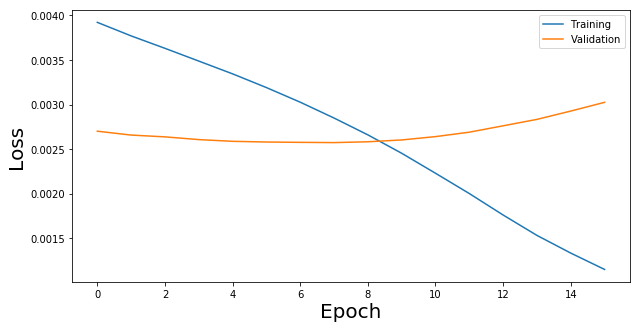

'\nprint("model 2")\nplt.figure(figsize=(10,5))\nplt.plot(model2.hist[\'train_loss\'][5::], label="Training")\nplt.plot(model2.hist[\'val_loss\'][5::], label="Validation")\n\nplt.xlabel("Epoch", fontsize=20)\nplt.ylabel("Loss", fontsize=20)\nplt.legend()\nplt.show()\n'

In [15]:

print("model 1")
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training")
plt.plot(model1.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()
"""
print("model 2")
plt.figure(figsize=(10,5))
plt.plot(model2.hist['train_loss'][5::], label="Training")
plt.plot(model2.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()
"""

#### Now plot the training and validation accuracies over the epochs.

model 1


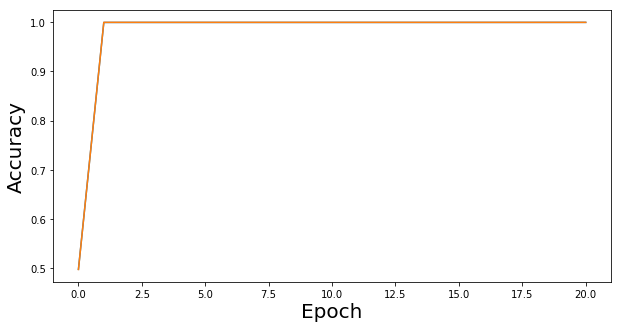

'\nprint("model 2")\nplt.figure(figsize=(10,5))\n\nplt.plot(model2.hist[\'train_accuracy\'])\nplt.plot(model2.hist[\'val_accuracy\'])\n\nplt.xlabel("Epoch", fontsize=20)\nplt.ylabel("Accuracy", fontsize=20)\n\nplt.show()\n'

In [18]:
print("model 1")
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'])
plt.plot(model1.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()
"""
print("model 2")
plt.figure(figsize=(10,5))

plt.plot(model2.hist['train_accuracy'])
plt.plot(model2.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()
"""

In [ ]:
train_acc_1 = model1.hist['train_accuracy'][-1]
val_acc_1 = model1.hist['val_accuracy'][-1]
"""
train_acc_2 = model2.hist['train_accuracy'][-1]
val_acc_2 = model2.hist['val_accuracy'][-1]
"""
print(f"Training accuracy model 1: {train_acc_1:.3f}")
print(f"Validation accuracy model 1: {val_acc_1:.3f}")
print()
"""
print(f"Training accuracy model 2: {train_acc_2:.3f}")
print(f"Validation accuracy model 2: {val_acc_2:.3f}")
print()
"""

### Plot the losses and accuracies of the models in one plot to compare them.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_loss'][5::], label="Validation model 1",
        color="darkgreen", linestyle="--")
"""
plt.plot(model2.hist['train_loss'][5::], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_loss'][5::], label="Validation model 2",
        color="royalblue", linestyle="--")
"""
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

## Comparing the models
Now, compare the final training and validation losses achieved by the different models.

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_accuracy'], label="Validation model 1",
        color="darkgreen", linestyle="--")

plt.plot(model2.hist['train_accuracy'], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_accuracy'], label="Validation model 2",
        color="royalblue", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
test_preds = NN_dropout_regularization.logits.eval({NN_dropout_regularization.X: test_data},
                                        session=NN_dropout_regularization.session).argmax(1)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices({"feature": train_data, "label": train_labels})
val_data = tf.data.Dataset.from_tensor_slices({"feature": val_data, "label": val_labels})
train_data

In [ ]:
train_data.output_types

In [ ]:
#build batches
batch_size = 500
train_data.shuffle(30000)
batches = dataset.batch(batch_size)

In [ ]:


sess = tf.Session()
iterator = batches.make_one_shot_iterator()
next_element = iterator.get_next()
no_of_batches = int(np.ceil(labels.shape[0] / batch_size))
counter = 1
for i in tqdm(range(no_of_batches)):
    value = sess.run(next_element)
    print(value["feature"].shape)
    print(counter)
    counter+=1

sess.close()